# Conflict Impact Analysis in Middle East, North Africa, Pakistan and Afghanistan

This analysis looks at conflicts between 2020 and 2024 in MENA + AP countries. Using ACLED data, we visualize number of events, conflict and conflict intensity index. 

ACLED consists of different event types and sub event types. For the purpose of this analysis, peaceful protests have not been considered.

In [366]:
%reload_ext autoreload
%autoreload 2

import os
import acled_conflict_analysis as acled
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

from datetime import date
from datetime import datetime
import geopandas as gpd
import pandas as pd
from conflict_visuals import *


In [371]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]
START_DATE = "2019-01-01"
END_DATE = "2024-12-31"

In [3]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [372]:
data = extraction.acled_api(
    email_address=os.environ.get("ACLED_EMAIL"),
    access_key=os.environ.get("ACLED_KEY"),
    countries=countries_of_interest,
    start_date=START_DATE,
    end_date=END_DATE
)

c:\WBG\Anaconda3\envs\acled\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [373]:
processing.data_type_conversion(data)

In [374]:
data = data[data['sub_event_type']!='Peaceful protest']

In [375]:
extracted_date = datetime.today().strftime('%Y%m%d')

last_date = data['event_date'].max()
last_date = last_date.strftime('%d %B %Y')
extracted_date_formatted = datetime.today().strftime('%d %B %Y')

In [377]:
data.to_csv(f'../../data/conflict/acled_mena_raw_no_peaceful_protest_{extracted_date}.csv')

In [28]:
conflict_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_national = conflict_national.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

data_no_protest = data[data['event_type'] != 'Protests']
conflict_national_no_protest = processing.get_acled_by_group(data_no_protest, columns=['country'], freq='YS')
conflict_national_no_protest = conflict_national_no_protest.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

In [31]:
conflict_national_event_type_monthly = processing.get_acled_by_group(data, columns=['country', 'event_type'], freq='MS')
conflict_national_event_type_monthly.to_csv(f'../../data/conflict/conflict_national_events_monthly_{extracted_date}.csv')

## Regional Events and Fatalities

In [33]:
conflict_national.loc[conflict_national['country']=='Palestine', 'country'] = 'West Bank and Gaza'
#regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

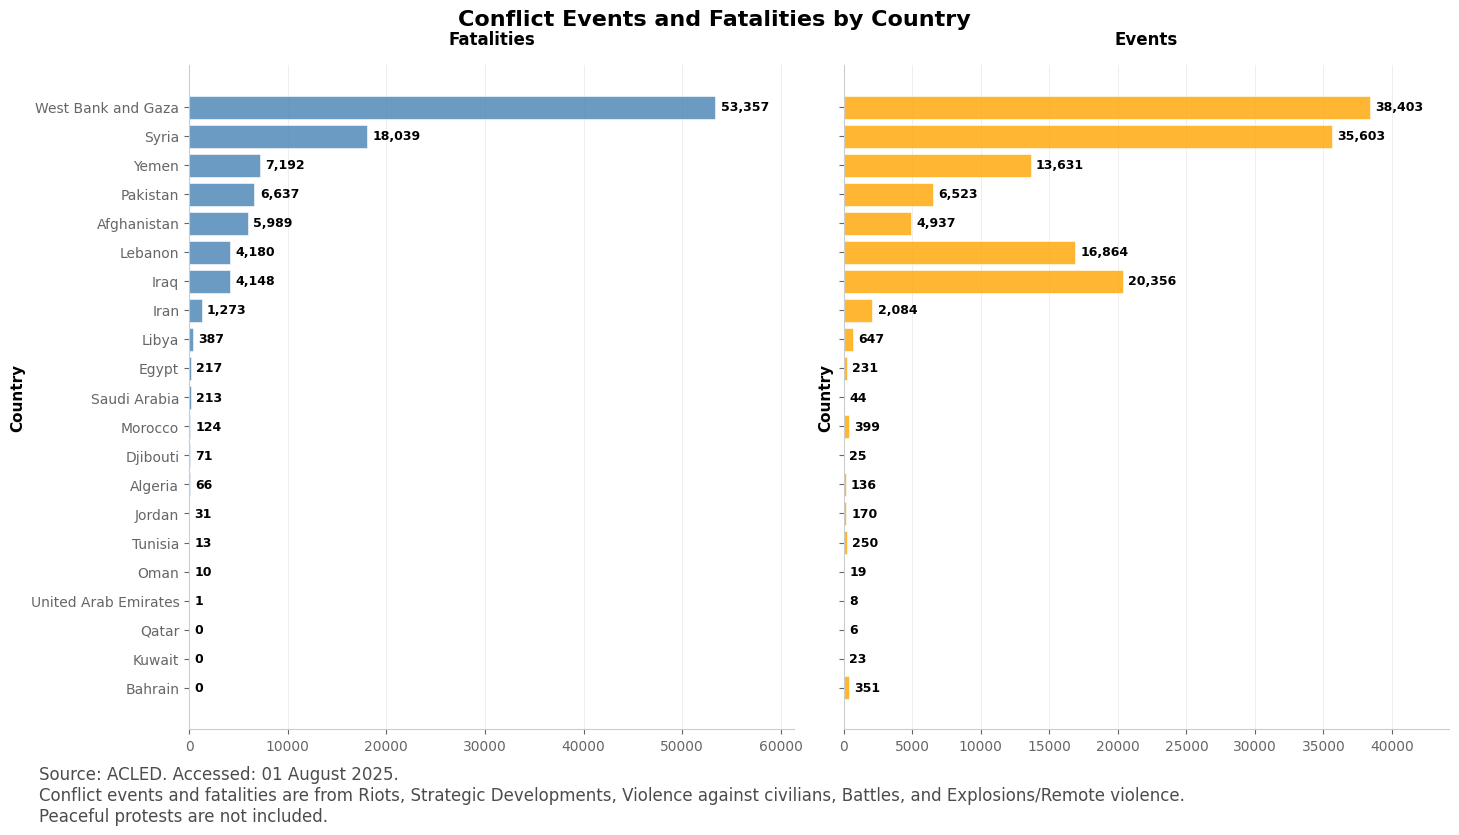

In [367]:
plot_dual_metrics_by_country(
    data =conflict_national,
    metrics_to_plot =['nrFatalities', 'nrEvents'],
    metric_display_info = {'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'},
                           'nrEvents': {'title': 'Events', 'color': 'orange'}},
    sorting_metric = 'nrFatalities',
    overall_title = 'Conflict Events and Fatalities by Country',
    subtitle = f"""Source: ACLED. Accessed: {extracted_date_formatted}.\nConflict events and fatalities are from Riots, Strategic Developments, Violence against civilians, Battles, and Explosions/Remote violence.\nPeaceful protests are not included."""
);

In [64]:
highest_15 = conflict_national[['country', 'nrFatalities']].sort_values(by='nrFatalities', ascending=False).head(15).reset_index(drop=True)['country'].tolist()

In [65]:
import glob
boundaries_adm0 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM0_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm0 = pd.concat([boundaries_adm0, gdf], ignore_index=True)

boundaries_adm1 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM1_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm1 = pd.concat([boundaries_adm1, gdf], ignore_index=True)

boundaries_adm2 = gpd.GeoDataFrame()

for file in glob.glob('../../data/boundaries/*_ADM2_*.geojson'):
    gdf = gpd.read_file(file)
    boundaries_adm2 = pd.concat([boundaries_adm2, gdf], ignore_index=True)

In [66]:
from boundaries_utils import *

In [110]:
#regional_boundary_quadkey7 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey7.gpkg')
regional_boundary_quadkey12 = gpd.read_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')
regional_boundary_quadkey12['country'] = regional_boundary_quadkey12['country'].apply(lambda x: get_country_name_from_iso_code(x))

In [111]:
def get_national_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column, 'country'], freq='YS')
    df = df.groupby([index_column, 'country'])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column, 'country'], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

def get_conflict_at_aggregation(boundary, index_column, data):
    df = processing.get_acled_by_admin(boundary[[index_column, 'geometry']], data, columns=[index_column], freq='YS')
    df = df.groupby([index_column])[['nrEvents', 'nrFatalities']].sum().reset_index()
    #df = df.merge(boundary[[index_column, 'geometry']], on=index_column, how='left')
    df = processing.calculate_conflict_index(df)
    df = df.merge(boundary, on=[index_column], how='left')
    df= gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')
    df['region'] = 'Middle East, North Africa, Afghanistan and Pakistan'

    return df

In [112]:
conflict_regional_quad12_quarter = processing.get_acled_by_admin(regional_boundary_quadkey12[['index', 'geometry']],data, ['index', 'country'], freq='QS')
conflict_regional_quad12_quarter = processing.calculate_conflict_index(conflict_regional_quad12_quarter)

In [113]:
conflict_regional_quad12_quarter.to_csv('../../data/conflict/conflict_quad12_regional_quarterly.csv')

In [296]:
conflict_national_h3_4 = get_conflict_at_aggregation(regional_boundary_h3_4, 'h3_index', data)
# conflict_national_q7 = get_national_conflict_at_aggregation(regional_boundary_quadkey7, 'index')
conflict_national_q12 = get_national_conflict_at_aggregation(regional_boundary_quadkey12, 'index', data)
# conflict_national_q12_noprotest= data[data['event_type'].isin(['Battles',  'Riots', 
#        'Explosions/Remote violence', 'Violence against civilians'])]
# conflict_national_q12_noprotest = get_national_conflict_at_aggregation(regional_boundary_quadkey12,'index', conflict_national_q12_noprotest )

In [73]:
#boundaries_quad12.reset_index().to_file('../../data/boundaries/MENAP_regional_quadkey12.gpkg')

## Geospatial Distribution of Conflict Intensity

In [365]:
conflict_national_h3_4.to_file('../../data/conflict/conflict_national_h3_4.geojson')

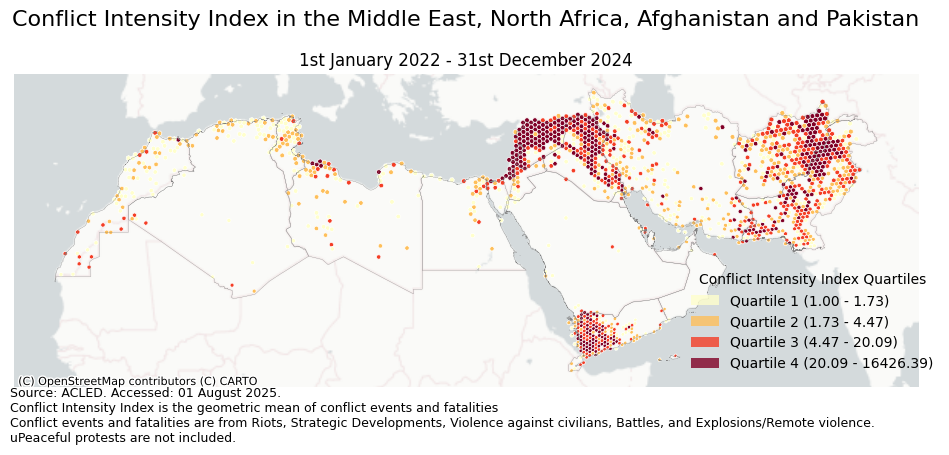

In [291]:
plot_h3_maps_with_boundaries_and_quartiles(
    conflict_national_h3_4,
    #title='Conflict Intensity Index at 1770 sq.km hex grids',
    category_column='region',
    measure_column='conflict_intensity_index',
    cmap_name='YlOrRd',
    boundary_gdf=boundaries_adm0,
    title = 'Conflict Intensity Index in the Middle East, North Africa, Afghanistan and Pakistan',
    source_text = f'Source: ACLED. Accessed: {extracted_date_formatted}.\nConflict Intensity Index is the geometric mean of conflict events and fatalities\nConflict events and fatalities are from Riots, Strategic Developments, Violence against civilians, Battles, and Explosions/Remote violence.\nuPeaceful protests are not included.',
    #subtitle_prefix='',
    #subplot_figsize_per_map=(10,4)
    );

In [292]:
conflict_event_monthly = processing.get_acled_by_group(data, columns=['country', 'event_type'], freq='MS')

### Which country saw the most widespread conflict?

1. We divided each country into ~2.4km grids
2. Every grid that had atleast one fatality/events was counted
3. Percentage of area where conflict occured is calculated

In [293]:
regional_boundary_grids = regional_boundary_quadkey12.groupby(['country']).count().reset_index()
regional_boundary_grids.rename(columns={'index':'nrGrids'}, inplace=True)

In [297]:
# Replace specific value in a column
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Iran, Islamic Republic of', 'country'] = 'Iran'
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Palestine, State of', 'country'] = 'Palestine'
regional_boundary_grids.loc[regional_boundary_grids['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

In [298]:
import numpy as np

def get_spread(conflict_national_h3_7, metric, column_name = 'nrGridswithFatalities'):
    conflict_spread = conflict_national_h3_7[conflict_national_h3_7[metric]>0].groupby('country')[metric].count().reset_index()
    print(len(conflict_spread['country'].unique()))
    conflict_spread = conflict_spread.rename(columns={metric:column_name})

    conflict_spread = conflict_spread.merge(regional_boundary_grids, on='country')
    print(len(conflict_spread['country'].unique()))
    conflict_spread['conflictArea'] = np.round(100*conflict_spread[column_name] / conflict_spread['nrGrids'],2)

    return conflict_spread

In [299]:
conflict_spread_fatalities = get_spread(conflict_national_q12, 'nrFatalities')
conflict_spread_events = get_spread(conflict_national_q12, 'nrEvents')

18
18
21
21


In [300]:
conflict_spread_events.rename(columns={'conflictArea': 'conflictAreaEvents'}, inplace=True)
conflict_spread_fatalities.rename(columns={'conflictArea': 'conflictAreaFatalities'}, inplace=True)
conflict_spread = conflict_spread_events.merge(conflict_spread_fatalities, on='country')

In [301]:
conflict_spread.loc[conflict_spread['country'] == 'Palestine', 'country'] = 'West Bank and Gaza'

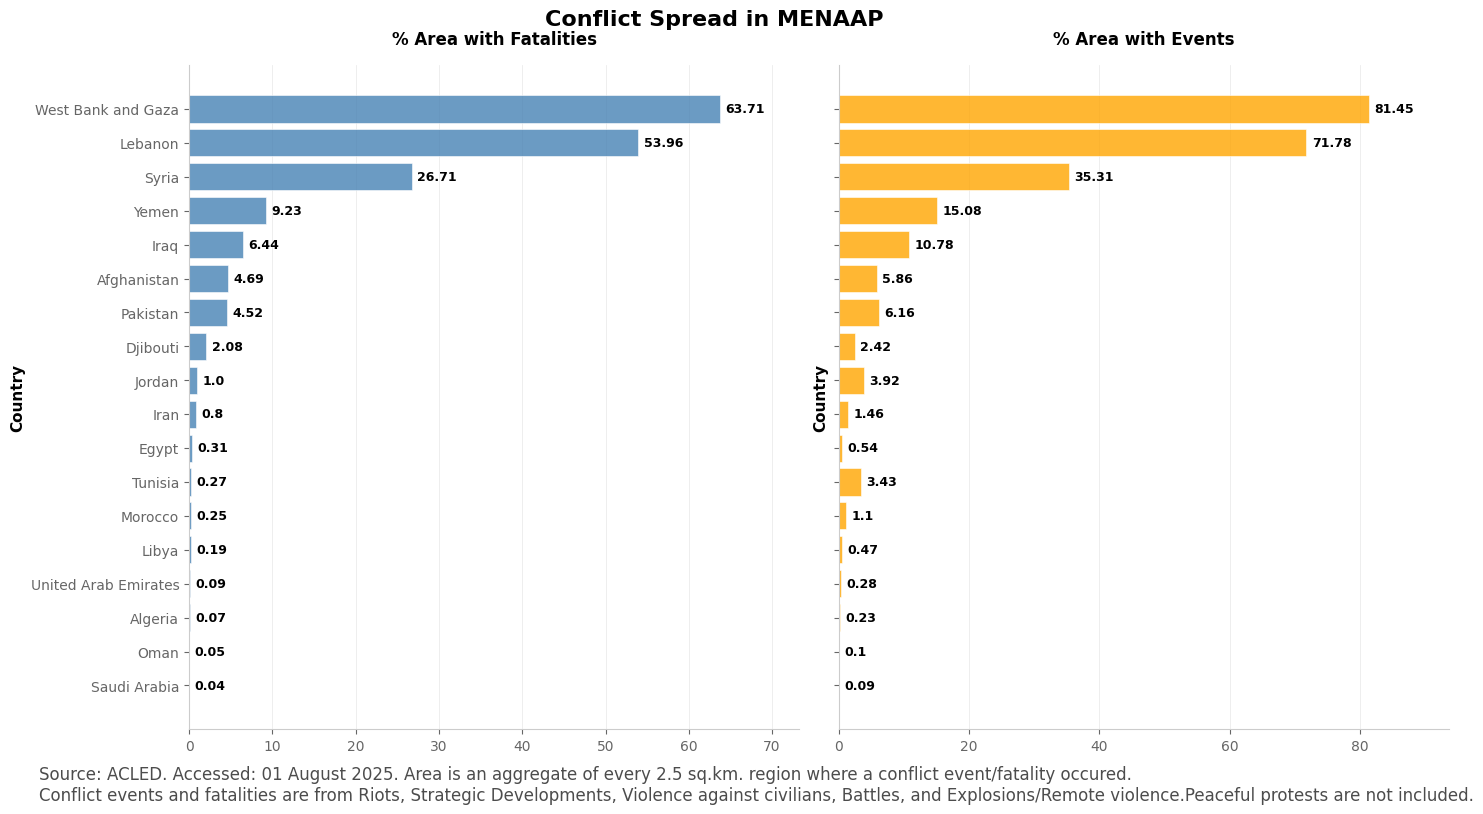

In [368]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =conflict_spread,
    metrics_to_plot =['conflictAreaFatalities', 'conflictAreaEvents'],
    metric_display_info = {'conflictAreaFatalities': {'title': '% Area with Fatalities', 'color': 'steelblue'},
                           'conflictAreaEvents': {'title': '% Area with Events', 'color': 'orange'}},
    sorting_metric = 'conflictAreaFatalities',
    overall_title = 'Conflict Spread in MENAAP',
    subtitle = f"""Source: ACLED. Accessed: {extracted_date_formatted}. Area is an aggregate of every 2.5 sq.km. region where a conflict event/fatality occured.\nConflict events and fatalities are from Riots, Strategic Developments, Violence against civilians, Battles, and Explosions/Remote violence.Peaceful protests are not included."""
);

## Conflict Temporal Trends

In [307]:
data['wb_region'] = 'MENAAP'

C:\Users\wb588851\AppData\Local\Temp\ipykernel_37916\860674668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['wb_region'] = 'MENAAP'


In [309]:
conflict_regional_yearly = processing.get_acled_by_group(data, ['wb_region'],freq='YS')
conflict_regional_monthly = processing.get_acled_by_group(data, ['wb_region'],freq='MS')

In [102]:
event_dict = {datetime(2023,10,8):'Start of the Gaza War'}

In [105]:
# output_file("bokeh_plot.html")
output_notebook()

df = conflict_regional_monthly
df['region'] = 'MENAAP'

tabs = []
labels = {"nrFatalities": "Number of Fatalities","nrEvents": "Number of Events"}

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                df,
                f"National Quarterly Trends in {labels[type]}",
                f"Figure shows annual total fatalities and conflict events, Data is available until {last_date}. \nSource: ACLED. Accessed {extracted_date_formatted}.",
                subtitle="",
                category="region",
                measure=type,
                event_date='event_date',
                #events_dict = event_dict,
                # plot_width=750,
                # plot_height=300
            ),
            title=type.capitalize(),    
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Population Impacted by Conflict

How many people were living in the same 2.5sq.km location where conflict events and fatalities occured?

In [327]:
pop = gpd.read_file('../../data/population/polygons/MENAAP_pop_quad12.gpkg')
pop_country = pop.groupby(['country'])['population'].sum().reset_index()
pop_country.rename(columns={'population':'totalPopulation', 'country':'country_code'}, inplace=True)

In [328]:
pop_country['country'] = pop_country['country_code'].apply(lambda x: get_country_name_from_iso_code(x))

In [329]:
# Replace specific value in a column
pop_country.loc[pop_country['country'] == 'Iran, Islamic Republic of', 'country'] = 'Iran'
pop_country.loc[pop_country['country'] == 'Palestine, State of', 'country'] = 'Palestine'
pop_country.loc[pop_country['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'

In [330]:
code_to_country = pop_country[['country_code', 'country']].drop_duplicates().set_index('country_code').to_dict()['country']
country_to_code = pop_country[['country_code', 'country']].drop_duplicates().set_index('country').to_dict()['country_code']

In [331]:
conflict_national_q12['country_code'] = conflict_national_q12['country'].map(country_to_code)
#conflict_national_q12_noprotest['country_code'] = conflict_national_q12_noprotest['country'].map(country_to_code)

In [332]:
pop.rename(columns={'country': 'country_code'}, inplace=True)
pop['country'] = pop['country_code'].map(code_to_country)

In [333]:
merged = conflict_national_q12.merge(pop[['index', 'population', 'country']],on=['index', 'country'], how='left')
merged = merged.groupby(['country', 'country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
merged = merged.merge(pop_country, on=['country_code', 'country'])

In [317]:
# merged_noprotest = conflict_national_q12_noprotest.merge(pop[['index', 'population', 'country']],on=['index', 'country'], how='left')
# merged_noprotest = merged_noprotest.groupby(['country', 'country_code'])[['nrEvents', 'nrFatalities', 'population']].sum().reset_index()
# merged_noprotest = merged_noprotest.merge(pop_country, on=['country', 'country_code'], how='left')

In [340]:
merged['pc_population'] = 100*merged['population']/merged['totalPopulation']

In [336]:
conflict_national_q12.to_file('../../data/conflict/conflict_quad12_regional.gpkg')

In [337]:
merged.loc[merged['country']=='Palestine', 'country'] = 'West Bank and Gaza'

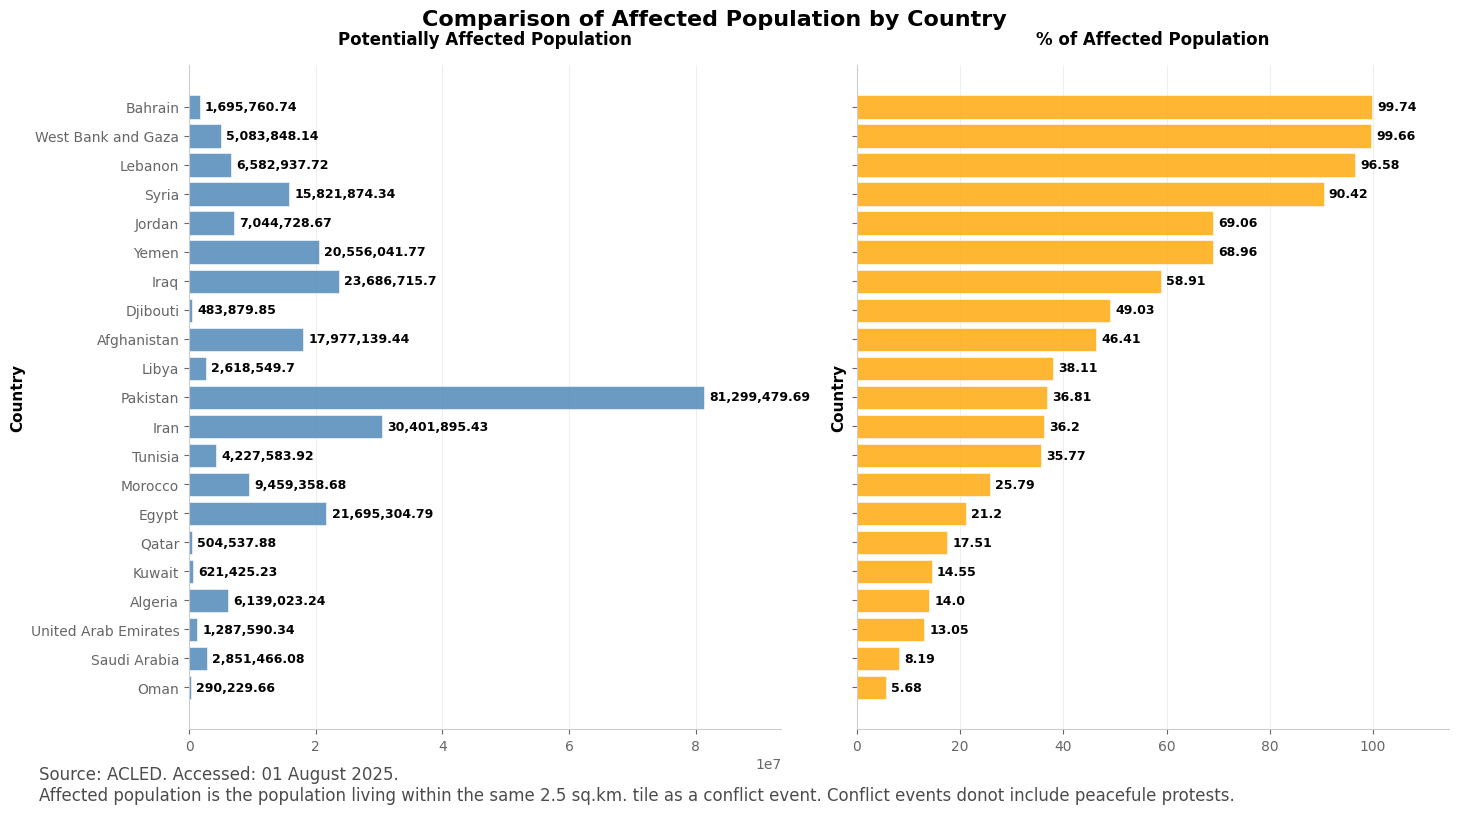

In [369]:
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('default')

plot_dual_metrics_by_country(
    data =merged,
    metrics_to_plot =['population', 'pc_population'],
    metric_display_info = {'population': {'title': 'Potentially Affected Population', 'color': 'steelblue'},
                           'pc_population': {'title': '% of Affected Population', 'color': 'orange'}},
    sorting_metric = 'pc_population',
    overall_title = 'Comparison of Affected Population by Country',
    subtitle = f'Source: ACLED. Accessed: {extracted_date_formatted}.\nAffected population is the population living within the same 2.5 sq.km. tile as a conflict event. Conflict events donot include peacefule protests.'
);

**99% of the population of West Bank and Gaza were impacted by the conflict.** While this isn't suprising, 79 million people in Pakistan are also living in conflict regions. Although Bahrain has a lot of conflict events, very few of them result in fatalities. 

The high affected population in Palestine could be because the WorldPop dataset marks most of the population to be living in the Gaza strip and not in the West Bank. 

## Conflict Type Trends

In [80]:
regional_conflict_event = processing.get_acled_by_group(data, ['event_type', 'sub_event_type'], freq ='MS')

### Regional Conflict Type Analysis

In [83]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import TabPanel, Tabs # Panel is deprecated in newer Bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
import bokeh.core.validation # Import the module to access silence
bokeh.core.validation.silence(MISSING_RENDERERS, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True) # Added for completeness if this also occurs

output_notebook() # Ensure this is called if running in a notebook environment

tabs = []

measures = regional_conflict_event['event_type'].unique()

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        regional_conflict_event[regional_conflict_event['event_type']==measure],
        title = f'{measure} Monthly Conflict Events',
        source=f"Source: ACLED. Accessed: {extracted_date_formatted}",
        category='sub_event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...

- The non violent transfer of territory took place in Syria, Yemen, Lebanon and Libya. In Lebanon, at the end of 2024,the Lebanese Armed Forces took control of southern Lebanon previously held by the Hezbollah. In 2024 December, Israeli forces took control of parts of Syria. 
- The uptick in the 'Non-state actor overtaking territory' alludes to the events occuring in Syria between the Syrian Democratic Forces, Syrian National Army, Tribal and Clain forces etc. 
- The number of air drone strikes in the region have incerased from 2022 to 2024. Non-state actors are involved in some of the drone attacks. 


In [360]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import TabPanel, Tabs # Panel is deprecated in newer Bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
import bokeh.core.validation # Import the module to access silence
bokeh.core.validation.silence(MISSING_RENDERERS, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True) # Added for completeness if this also occurs

output_notebook() # Ensure this is called if running in a notebook environment



tabs = []

measures = countries_of_interest

conflict_event_monthly = conflict_event_monthly.sort_values(by=['country', 'event_type'])

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        conflict_event_monthly[conflict_event_monthly['country'] == measure],
        title = f'{measure} Monthly Conflict Events',
        source=f"Source: ACLED. Accessed: {extracted_date_formatted}. Data does not include peaceful protests.",
        category='event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...